Begun 2/8/25

Analysis of a test run of calculating the TT calibration factor with the full likelihood for nine maps.

Results are in angle_calc_1739043336

In [1]:
import numpy as np
from pixell import enmap, enplot, bunch
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import scipy
from scipy import optimize as op
from scipy.stats.distributions import chi2

In [2]:
# Loading spectra from run
spectra_dict = np.load('/home/zbh5/act_analysis/act_axion_analysis/results/angle_calc_1739043336/angle_calc_1739043336_spectra.npy',allow_pickle=True).item()

In [22]:
maps = np.array(list(spectra_dict.keys()))
print(maps)
n_maps = len(maps)
print(n_maps)
print(spectra_dict[maps[0]].keys())

['depth1_1494735603_pa4_f150_map.fits'
 'depth1_1494735603_pa5_f150_map.fits'
 'depth1_1494735603_pa6_f150_map.fits'
 'depth1_1494743515_pa4_f150_map.fits'
 'depth1_1494743515_pa5_f150_map.fits'
 'depth1_1494743515_pa6_f150_map.fits'
 'depth1_1494761700_pa4_f150_map.fits'
 'depth1_1494761700_pa5_f150_map.fits'
 'depth1_1494761700_pa6_f150_map.fits']
9
dict_keys(['ell', 'E1xB2', 'E2xB1', 'E1xE1', 'B2xB2', 'E2xE2', 'B1xB1', 'E1xE2', 'B1xB2', 'E1xB1', 'E2xB2', 'binned_nu', 'estimator', 'covariance', 'CAMB_EE', 'CAMB_BB', 'w2_depth1', 'w2_cross', 'w2_ref', 'fsky', 'w2w4_depth1', 'w2w4_cross', 'w2w4_ref', 'meas_angle', 'meas_errbar', 'initial_timestamp', 'median_timestamp', 'ivar_sum', 'residual_mean', 'residual_sum', 'map_cut', 'T1xcal1T', 'cal1Txcal2T', 'cal1Txcal1T', 'cal2Txcal2T', 'T1xT1', 'T1xcal2T', 'cal_factor', 'cal_factor_errbar', 'w2_depth1xcal1', 'w2_depth1xcal2', 'w2_cal1xcal2', 'w2_cal1xcal1', 'w2_cal2xcal2', 'w2w4_cal', 'w2w4_depth1xcal1', 'w2w4_cal1xcal2'])


In [4]:
cut_flags = np.zeros(n_maps)
cal_factors = np.zeros(n_maps)
cal_factor_errbars = np.zeros(n_maps)
for i in range(n_maps):
    cut_flags[i] = spectra_dict[maps[i]]['map_cut']
    cal_factors[i] = spectra_dict[maps[i]]['cal_factor']
    cal_factor_errbars[i] = spectra_dict[maps[i]]['cal_factor_errbar']

# Extracting map info and results into separate arrays for ease of access
# Not using numpy arrays at first to more easily put strings and arrays in the list
map_arrays = []
map_timestamps = []
all_cal1xcal2 = []
all_cal1xdepth1 = []
all_cal1xcal1 = []
all_depth1xdepth1 = []
all_cal2xdepth1 = []
all_cal2xcal2 = []
all_cal_binned_nu = []

for i in range(n_maps):
    map_arrays.append(maps[i].split('_')[2])
    map_timestamps.append(maps[i].split('_')[1])
    all_cal1xcal2.append(spectra_dict[maps[i]]['cal1Txcal2T'])
    all_cal1xdepth1.append(spectra_dict[maps[i]]['T1xcal1T'])
    all_cal1xcal1.append(spectra_dict[maps[i]]['cal1Txcal1T'])
    all_depth1xdepth1.append(spectra_dict[maps[i]]['T1xT1'])
    all_cal2xdepth1.append(spectra_dict[maps[i]]['T1xcal2T'])
    all_cal2xcal2.append(spectra_dict[maps[i]]['cal2Txcal2T'])
    all_cal_binned_nu.append(spectra_dict[maps[i]]['w2w4_cal']*spectra_dict[maps[i]]['binned_nu']/spectra_dict[maps[i]]['w2w4_cross'])
map_arrays = np.array(map_arrays)
map_timestamps = np.array(map_timestamps)
all_cal1xcal2 = np.array(all_cal1xcal2)
all_cal1xdepth1 = np.array(all_cal1xdepth1)
all_cal1xcal1 = np.array(all_cal1xcal1)
all_depth1xdepth1 = np.array(all_depth1xdepth1)
all_cal2xdepth1 = np.array(all_cal2xdepth1)
all_cal2xcal2 = np.array(all_cal2xcal2)
all_cal_binned_nu = np.array(all_cal_binned_nu)
all_cal_cov = ((1/all_cal_binned_nu)*((all_cal1xcal1*all_cal2xcal2+all_cal1xcal2**2)
                                         +(all_depth1xdepth1*all_cal1xcal1+all_cal1xdepth1**2)
                                       -2*(all_cal1xdepth1*all_cal1xcal2+all_cal1xcal1*all_cal2xdepth1)))

In [5]:
def cal_likelihood(y, cal1xcal2, cal1xdepth1, covariance):
    """
        Calculates the likelihood for TT calibration for an input
        value of the calibration factor, y.

        estimator = TT_cal1xcal2 - y*TT_cal1xdepth1
    """
    numerator = (cal1xcal2 - y*cal1xdepth1)**2
    denominator = 2*covariance
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def gaussian(x,mean,sigma):
    """Normalized Gaussian for curve_fit"""
    amp = 1.0
    return amp*np.exp(-(x-mean)**2/(2*sigma**2))

def gaussian_fit_curvefit(angles,data,guess=[1.0*np.pi/180.0, 5.0*np.pi/180.0]):
    """
        Uses scipy.optimize.curve_fit() to fit a Gaussian to the likelihood to
        get the mean and standard deviation.

        Assumes everything is in radians when fitting angles.

        The default guess (mean 1 deg, std dev 5 deg) here is for the angle likelihood. 
        When using this function to fit the TT calibration likelihood, pass in a different guess.
    """
    popt, pcov = op.curve_fit(gaussian,angles,data,guess,maxfev=50000)
    mean = popt[0]
    std_dev = np.abs(popt[1])
    return mean, std_dev

def gaussian_fit_moment(angles,data):
    """
       Uses moments to quickly find mean and standard deviation of a Gaussian
       for the likelihood.

       Assumes everything is in radians when fitting angles.
    """
    mean = np.sum(angles*data)/np.sum(data)
    std_dev = np.sqrt(abs(np.sum((angles-mean)**2*data)/np.sum(data)))
    return mean, std_dev

def cal_sample_likelihood_and_fit(cal1xcal2, cal1xdepth1, covariance, y_min=0.7,y_max=1.3,
                              num_pts=50000,use_curvefit=True,plot=True,map_fname=None):
    """
        Samples the likelihood for the TT calibration at num_pts values of the calibration
        factor, y, between the values y_min and y_max.
    """
    if(y_min >= y_max): 
        raise ValueError("The min y value must be smaller than the max!")
    y_values = np.linspace(y_min,y_max,num=num_pts)
    
    cal_sampled_likelihood = [cal_likelihood(y, cal1xcal2, cal1xdepth1, covariance) for y in y_values]
    norm_sampled_likelihood = cal_sampled_likelihood/np.max(cal_sampled_likelihood)

    if use_curvefit:
        # The default guess starting values are for the angle likelihood, so pass new ones here
        guess = [0.95, 0.1] # Guessing a center value of 1.0 with std dev 0.2
        fit_values = gaussian_fit_curvefit(y_values,norm_sampled_likelihood, guess=guess)
    else:
        fit_values = gaussian_fit_moment(y_values,norm_sampled_likelihood)
    
    if plot:
        map_name = os.path.split(map_fname)[1][:-9] # removing "_map.fits"
        mean = fit_values[0]
        stddev = fit_values[1]
        fig = plt.figure(figsize=(6.4,4.8), layout='constrained')
        plt.plot(y_values,norm_sampled_likelihood,'b.',label='Mean={:1.3f}\n$\sigma$={:1.3f}'.format(mean,stddev))
        plt.axvline(mean,alpha=0.5,color='black')
        plt.plot(y_values, gaussian(y_values,mean,stddev), 'r', label='Fit Gaussian')
        plt.legend()
        plt.ylabel("Likelihood")
        plt.xlabel("Calibration factor (unitless)")
        plt.grid()
        plt.title("TT Cal Likelihood " + map_name)
        plt.show()
        plt.close()

    return fit_values

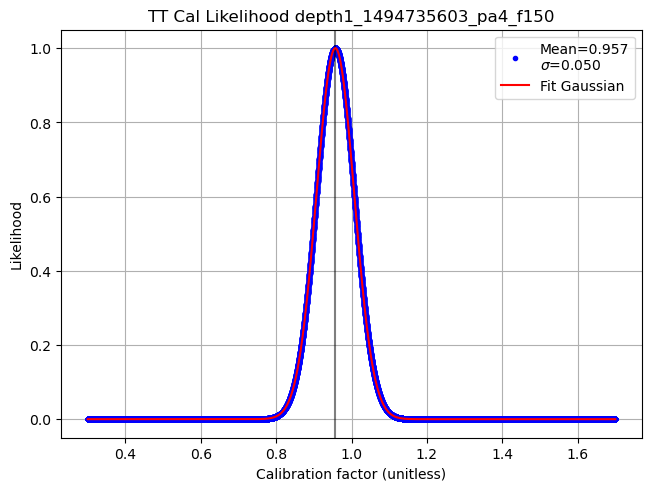

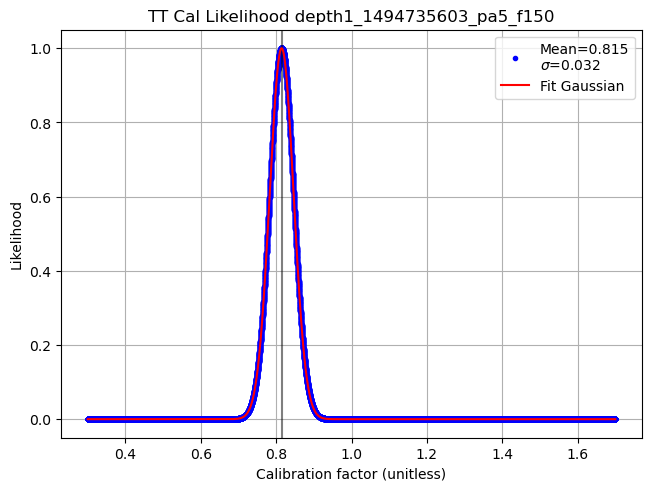

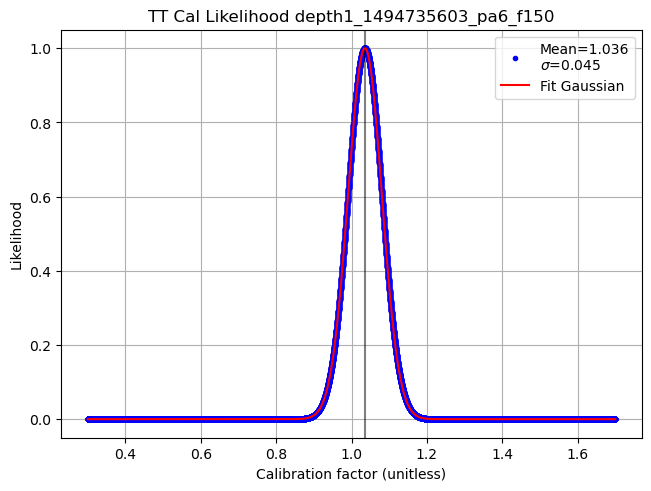

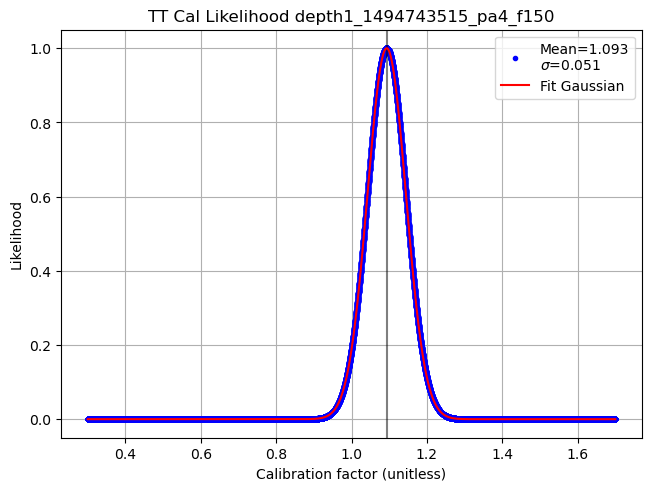

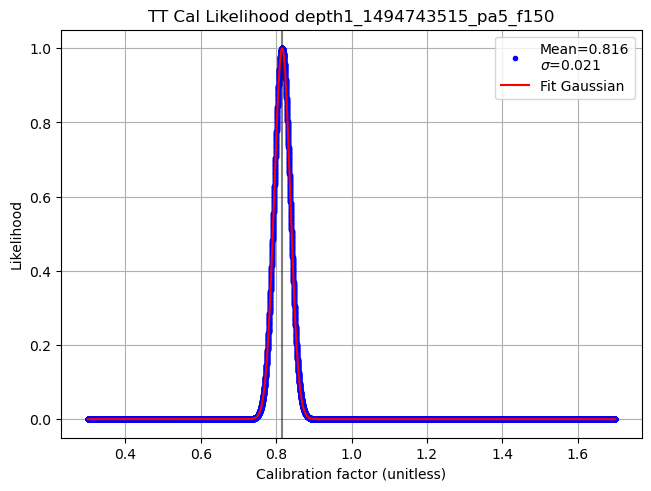

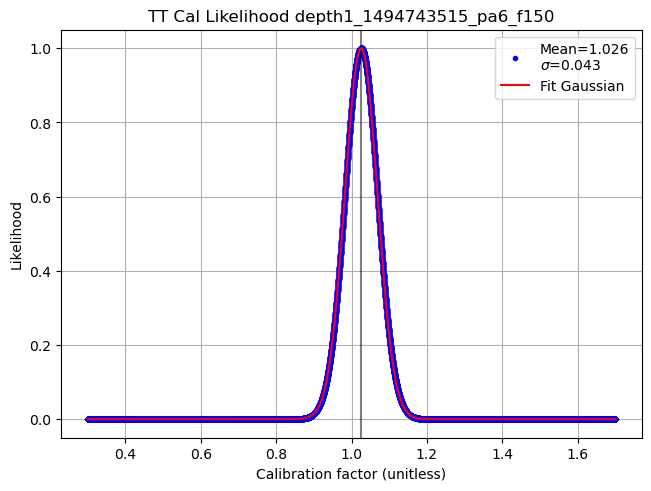

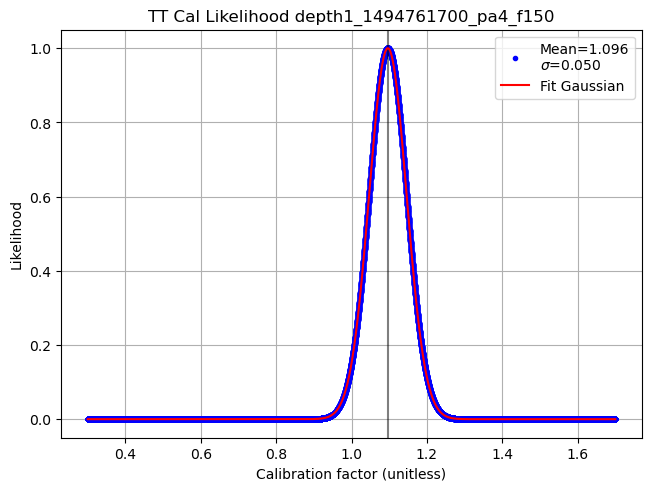

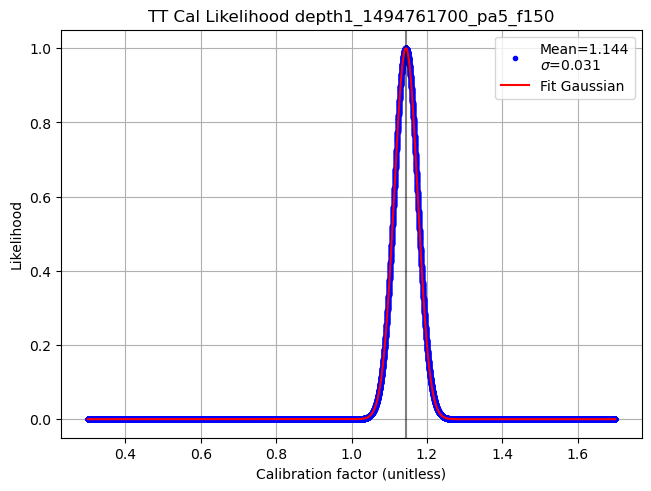

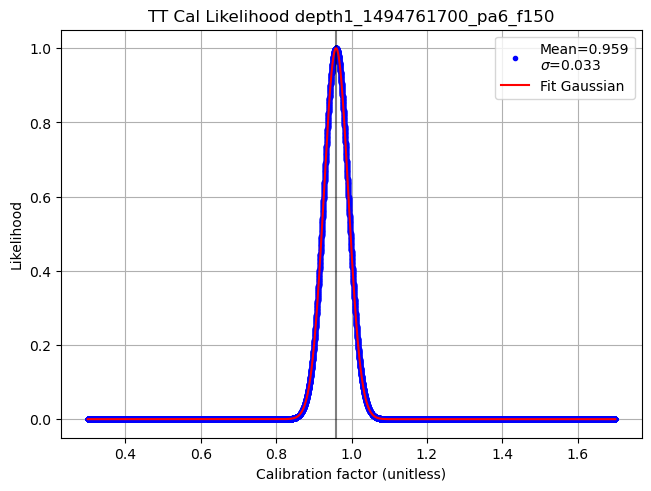

In [47]:
num_pts = 20000
y_min = 0.3
y_max = 1.7

all_fit_values = np.zeros(n_maps)
all_fit_errbars = np.zeros(n_maps)

for i in range(n_maps):
    cal_fit_values = cal_sample_likelihood_and_fit(all_cal1xcal2[i], all_cal1xdepth1[i], all_cal_cov[i], 
                                            y_min=y_min,y_max=y_max,num_pts=num_pts,use_curvefit=False,
                                                   plot=True,map_fname=maps[i])
    all_fit_values[i] = cal_fit_values[0]
    all_fit_errbars[i] = cal_fit_values[1]

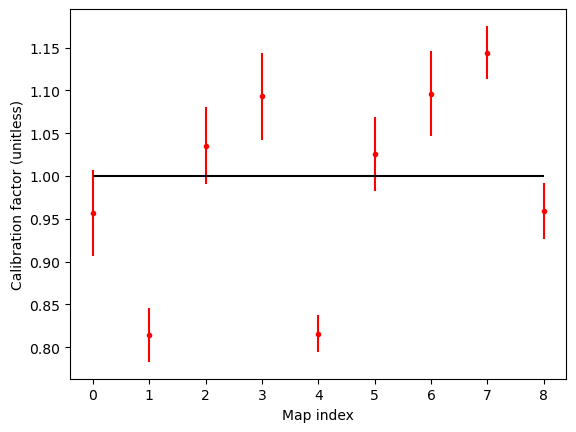

In [53]:
plt.errorbar(range(n_maps),all_fit_values,yerr=all_fit_errbars,fmt='r.')
plt.hlines(1.0,0.0,n_maps-1,'black')
plt.ylabel('Calibration factor (unitless)')
plt.xlabel('Map index')
plt.show()
plt.close()

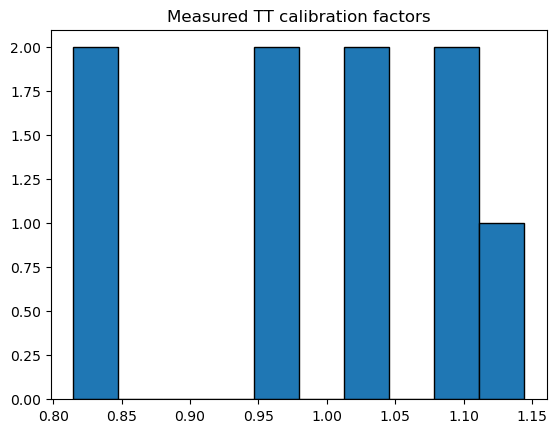

In [7]:
plt.hist(all_fit_values, color='tab:blue', edgecolor='black')
plt.title("Measured TT calibration factors")
plt.show()
plt.close()

In [39]:
# Checking chi2 for the model fit of estimator-theory
# Not sure how to account for errorbar on y in the covariance yet
chi2_good_maps = []
pte_good_maps = []

for i in range(n_maps):
    null = all_cal1xcal2[i] - all_fit_values[i]*all_cal1xdepth1[i]
    sum_cov = all_cal_cov[i]
    chi2_good_map = np.sum(null**2/(1.0*sum_cov))
    dof_good_map = null.size - 1 # Should be the same each time
    pte_good_map = chi2.sf(chi2_good_map,dof_good_map)
    chi2_good_maps.append(chi2_good_map)
    pte_good_maps.append(pte_good_map)

chi2_good_maps = np.array(chi2_good_maps)
pte_good_maps = np.array(pte_good_maps)

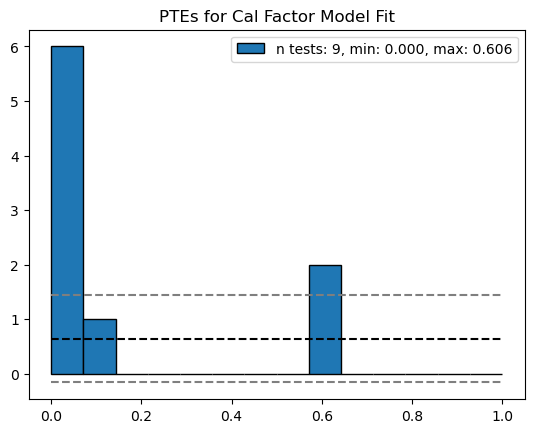

In [40]:
nbins = 14
plt.hist(pte_good_maps,bins=nbins,range=(0.0,1.0), color='tab:blue', edgecolor='black',
              label=f'n tests: {len(pte_good_maps)}, min: {np.min(pte_good_maps):.3f}, max: {np.max(pte_good_maps):.3f}')
per_bin_avg = len(pte_good_maps)/nbins
per_bin_err = np.sqrt(per_bin_avg) 
plt.hlines(per_bin_avg, 0.0, 1.0, colors='black', linestyles='dashed')
plt.hlines(per_bin_avg+per_bin_err, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
plt.hlines(per_bin_avg-per_bin_err, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
plt.title("PTEs for Cal Factor Model Fit")
plt.legend()
plt.show()
plt.close()

In [10]:
# loading and binning CAMB TT
bin_size = 400
lmin = 1000
lmax = 3001
bins = np.arange(lmin, lmax, bin_size)
centers = (bins[1:] + bins[:-1])/2.0

camb_file = "/home/zbh5/act_analysis/act_axion_analysis/resources/camb_19413797_lensedtotcls.dat"
ell_camb,DlTT_camb = np.loadtxt(camb_file, usecols=(0,1), unpack=True)
# Note that ell runs from 2 to 5400
arr_len = ell_camb.size + 2
ell = np.zeros(arr_len)
ell[1] = 1.0
ell[2:] = ell_camb
ClTT = np.zeros(arr_len)
ClTT[2:] = DlTT_camb * 2 * np.pi / (ell_camb*(ell_camb+1.0))
digitized = np.digitize(ell, bins, right=True)
CAMB_ClTT_binned = np.bincount(digitized, ClTT.reshape(-1))[1:-1]/np.bincount(digitized)[1:-1]

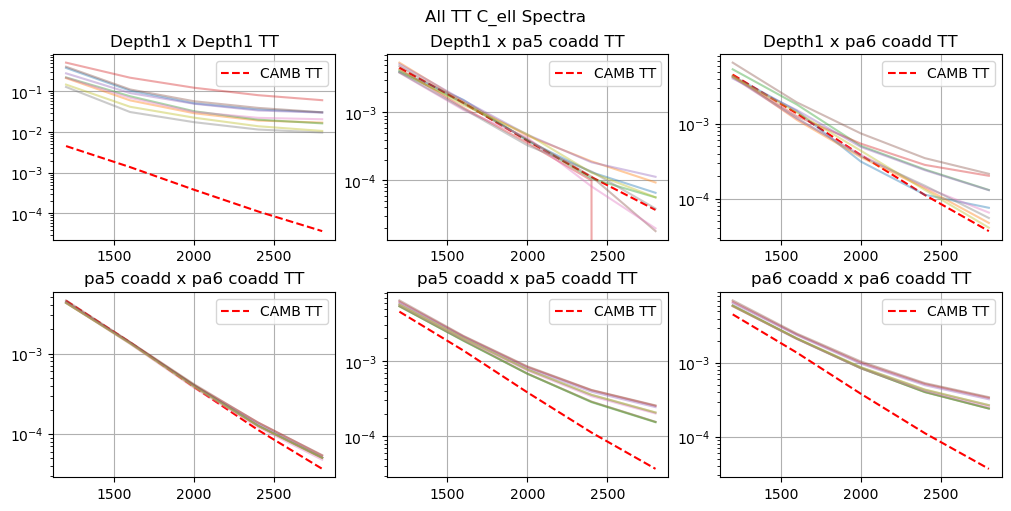

In [26]:
# Plotting all the TT spectra
fig, axs = plt.subplots(2,3,constrained_layout=True, figsize=(10,5))
fig.suptitle("All TT C_ell Spectra")
axs[0,0].set_title("Depth1 x Depth1 TT")
axs[0,1].set_title("Depth1 x pa5 coadd TT")
axs[0,2].set_title("Depth1 x pa6 coadd TT")
axs[1,0].set_title("pa5 coadd x pa6 coadd TT")
axs[1,1].set_title("pa5 coadd x pa5 coadd TT")
axs[1,2].set_title("pa6 coadd x pa6 coadd TT")

axs[0,0].semilogy(centers, CAMB_ClTT_binned, 'r--', label='CAMB TT')
axs[0,1].semilogy(centers, CAMB_ClTT_binned, 'r--', label='CAMB TT')
axs[0,2].semilogy(centers, CAMB_ClTT_binned, 'r--', label='CAMB TT')
axs[1,0].semilogy(centers, CAMB_ClTT_binned, 'r--', label='CAMB TT')
axs[1,1].semilogy(centers, CAMB_ClTT_binned, 'r--', label='CAMB TT')
axs[1,2].semilogy(centers, CAMB_ClTT_binned, 'r--', label='CAMB TT')
for i in range(n_maps):
#for i in [2,5,8]: # pa6
#for i in [1,4,7]: # pa5
#for i in [0,3,6]: # pa4
    axs[0,0].semilogy(centers, all_depth1xdepth1[i], alpha=0.4)
    axs[0,1].semilogy(centers, all_cal1xdepth1[i], alpha=0.4)
    axs[0,2].semilogy(centers, all_cal2xdepth1[i], alpha=0.4)
    axs[1,0].semilogy(centers, all_cal1xcal2[i], alpha=0.4)
    axs[1,1].semilogy(centers, all_cal1xcal1[i], alpha=0.4)
    axs[1,2].semilogy(centers, all_cal2xcal2[i], alpha=0.4)
axs[0,0].legend()
axs[0,1].legend()
axs[0,2].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[1,2].legend()
axs[0,0].grid()
axs[0,1].grid()
axs[0,2].grid()
axs[1,0].grid()
axs[1,1].grid()
axs[1,2].grid()
plt.show()
plt.close()

In [27]:
def cl_to_dl(cl, ell):
    """Helper function to convert C_ell to D_ell"""
    return cl*ell*(ell+1.0) / (2.0 * np.pi)

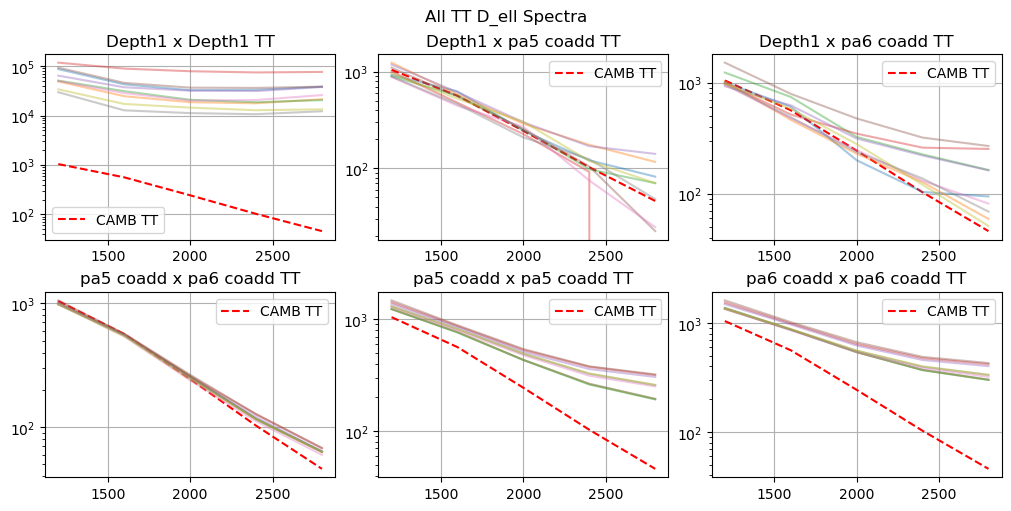

In [28]:
# Plotting all the TT spectra
fig, axs = plt.subplots(2,3,constrained_layout=True, figsize=(10,5))
fig.suptitle("All TT D_ell Spectra")
axs[0,0].set_title("Depth1 x Depth1 TT")
axs[0,1].set_title("Depth1 x pa5 coadd TT")
axs[0,2].set_title("Depth1 x pa6 coadd TT")
axs[1,0].set_title("pa5 coadd x pa6 coadd TT")
axs[1,1].set_title("pa5 coadd x pa5 coadd TT")
axs[1,2].set_title("pa6 coadd x pa6 coadd TT")

axs[0,0].semilogy(centers, cl_to_dl(CAMB_ClTT_binned,centers), 'r--', label='CAMB TT')
axs[0,1].semilogy(centers, cl_to_dl(CAMB_ClTT_binned,centers), 'r--', label='CAMB TT')
axs[0,2].semilogy(centers, cl_to_dl(CAMB_ClTT_binned,centers), 'r--', label='CAMB TT')
axs[1,0].semilogy(centers, cl_to_dl(CAMB_ClTT_binned,centers), 'r--', label='CAMB TT')
axs[1,1].semilogy(centers, cl_to_dl(CAMB_ClTT_binned,centers), 'r--', label='CAMB TT')
axs[1,2].semilogy(centers, cl_to_dl(CAMB_ClTT_binned,centers), 'r--', label='CAMB TT')
for i in range(n_maps):
#for i in [2,5,8]: # pa6
#for i in [1,4,7]: # pa5
#for i in [0,3,6]: # pa4
    axs[0,0].semilogy(centers, cl_to_dl(all_depth1xdepth1[i],centers), alpha=0.4)
    axs[0,1].semilogy(centers, cl_to_dl(all_cal1xdepth1[i],centers), alpha=0.4)
    axs[0,2].semilogy(centers, cl_to_dl(all_cal2xdepth1[i],centers), alpha=0.4)
    axs[1,0].semilogy(centers, cl_to_dl(all_cal1xcal2[i],centers), alpha=0.4)
    axs[1,1].semilogy(centers, cl_to_dl(all_cal1xcal1[i],centers), alpha=0.4)
    axs[1,2].semilogy(centers, cl_to_dl(all_cal2xcal2[i],centers), alpha=0.4)
axs[0,0].legend()
axs[0,1].legend()
axs[0,2].legend()
axs[1,0].legend()
axs[1,1].legend()
axs[1,2].legend()
axs[0,0].grid()
axs[0,1].grid()
axs[0,2].grid()
axs[1,0].grid()
axs[1,1].grid()
axs[1,2].grid()
plt.show()
plt.close()

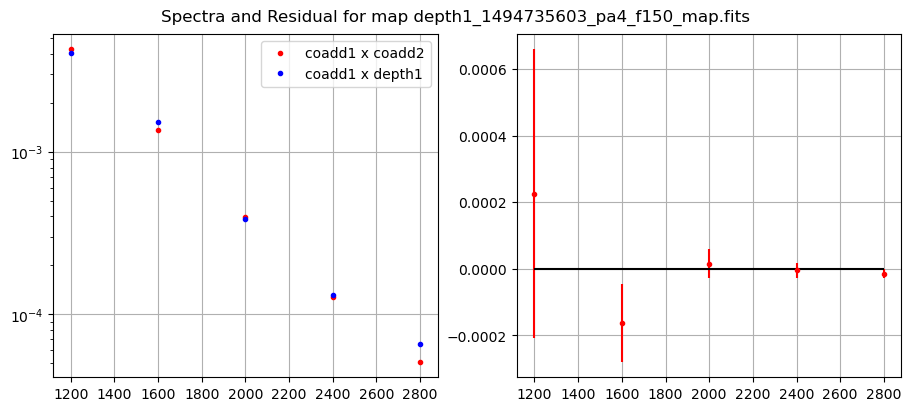

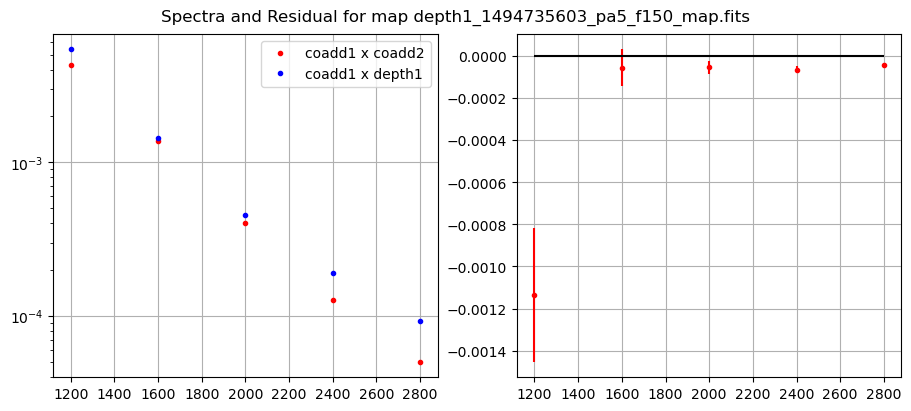

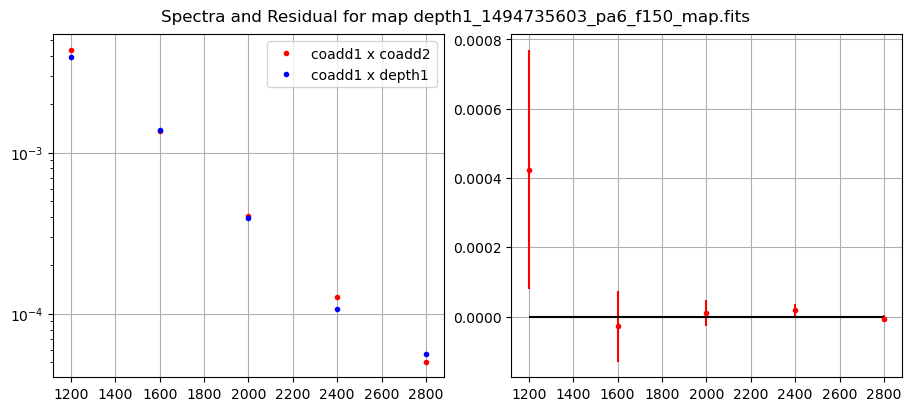

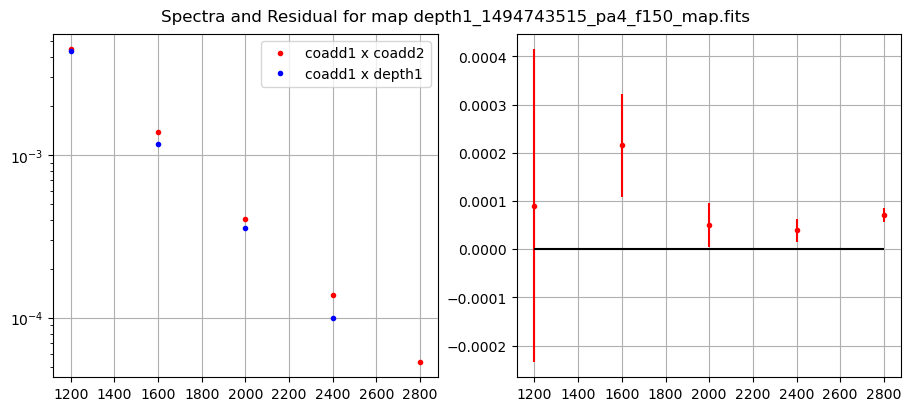

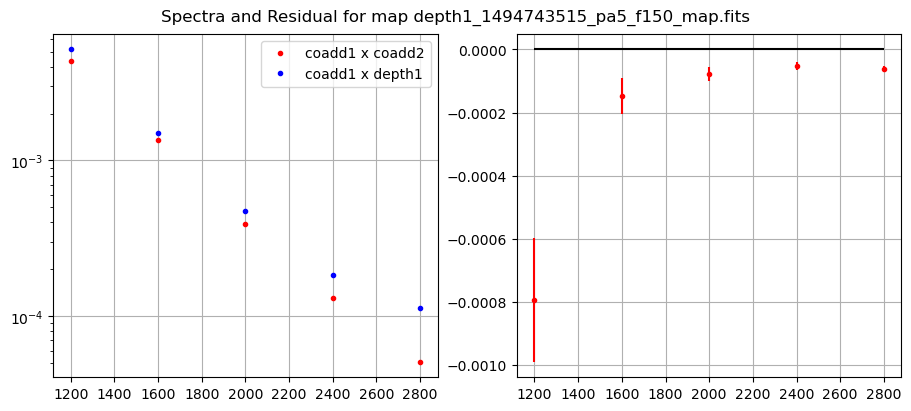

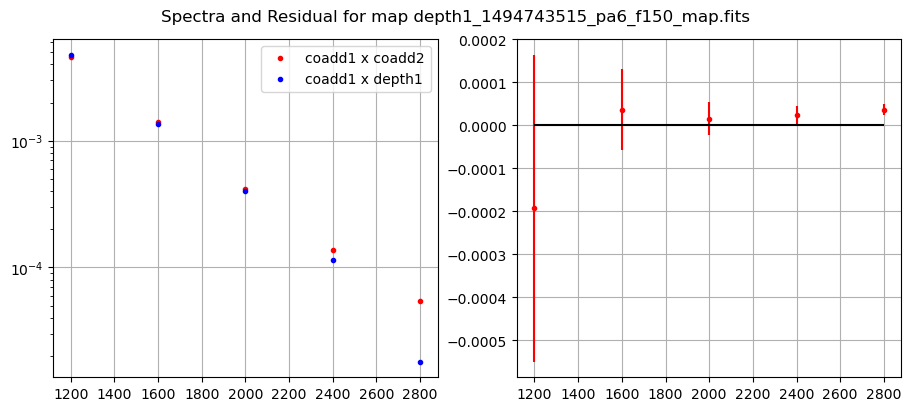

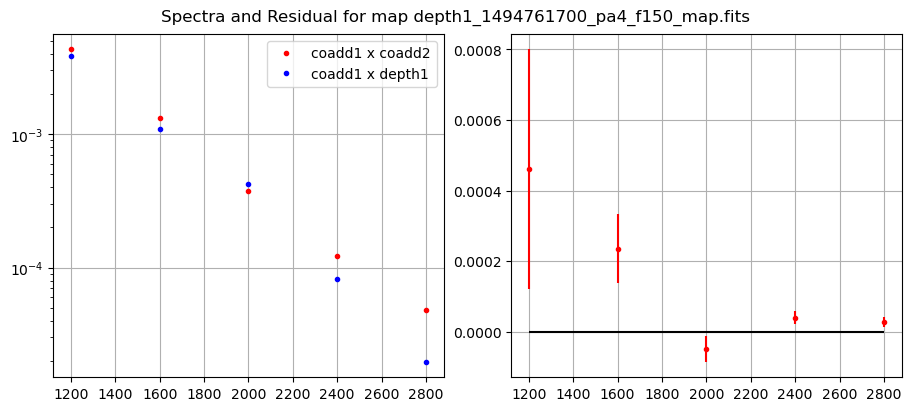

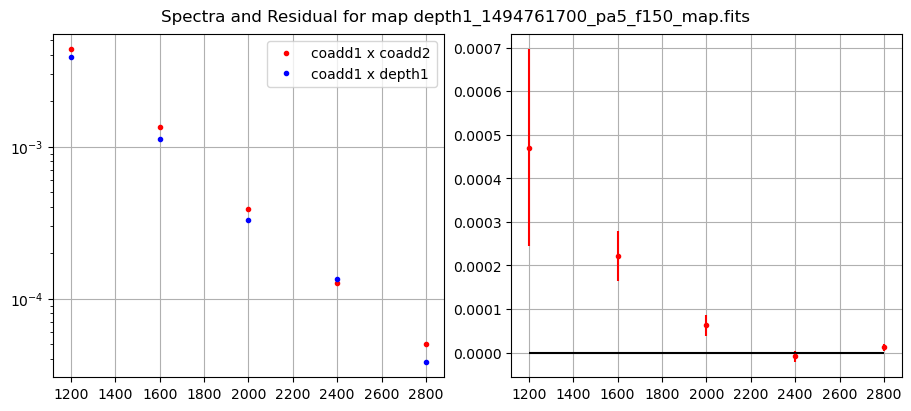

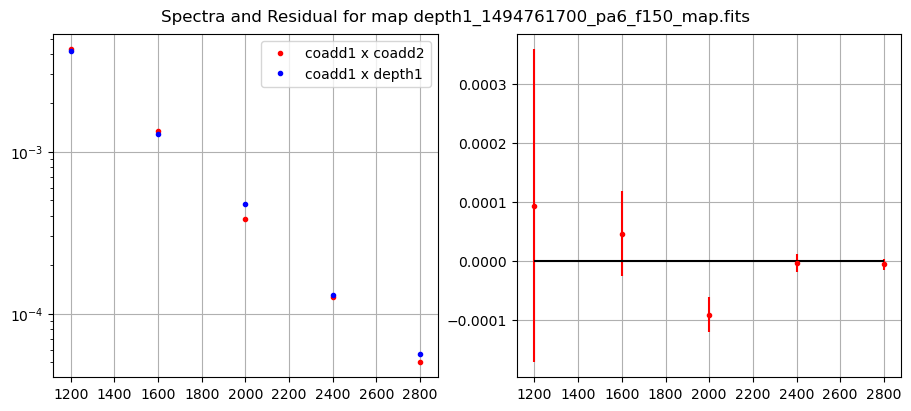

In [44]:
# Plotting the estimator residual for each map
for i in range(n_maps):
    fig, axs = plt.subplots(1,2,constrained_layout=True, figsize=(9,4))
    fig.suptitle("Spectra and Residual for map "+maps[i])
    axs[0].semilogy(centers,all_cal1xcal2[i],'r.',label='coadd1 x coadd2')
    axs[0].semilogy(centers,all_cal1xdepth1[i],'b.',label='coadd1 x depth1')
    axs[0].grid()
    axs[0].legend()
    axs[1].errorbar(centers,all_cal1xcal2[i]-all_cal1xdepth1[i],yerr=np.sqrt(all_cal_cov[i]),fmt='r.')
    axs[1].hlines(0.0,centers[0],centers[-1],'black')
    axs[1].grid()
    plt.show()
    plt.close()